# Trabajo Final - Prediccion Modelo PQL

## Importacion de librerias

<b>Paso 0.</b> Importacion de las librerias de python

In [1]:
#Importacion de numpy
import numpy as np
#Importacion de pandas
import pandas as pd
#Importacion de pyplot
import matplotlib.pyplot as plt
#Importacion de seaborn
import seaborn as sns
#Importacion de pickle
import pickle

## Proceso de ETL

<b>Paso 1.</b> Funcion que permite cambiar el nombre de las columnas de un DataFrame

In [2]:
def cambiarNombreColumnas(dfCambiar,headers):
    
    for i in range(dfCambiar.columns.size):
        
        #Se extrae el nombre actual de la columna
        nombreAnterior = dfCambiar.columns[i]
        
        #Se ectrae el nombre nuevo de la columna
        nombreNuevo = headers.loc[i][0]
    
        #Se cambi el nombre de la columna
        dfCambiar = dfCambiar.rename(columns={nombreAnterior:nombreNuevo})
        
    return dfCambiar

<b>Paso 2.</b> Funcion que lee la informacion de un archivo de Excel

In [3]:
def lecturaInicial(path):
    
    #Se lee el archivo del PQL y se convierte en un Data Frame
    dfInicial = pd.read_excel(path,sheet_name='RapidMiner Data',encoding='latin-1')

    #Se lee el archivo de los encabezados y se convierte en DataFrame
    dfHeaders = pd.read_csv("../01. Flat Files/data_PQL_headers.txt")

    #Se cambi el nombre de las columnas
    dfInicial = cambiarNombreColumnas(dfInicial,dfHeaders)
    
    #Se elimina el DataFrame de encabeados
    del dfHeaders

    return dfInicial

<b>Paso 3.</b> Funcion que realiza el tratamiento de los nulos

In [4]:
def manejoNulos (dfRemplazar):
    
    #Se obtiene el ultimo valor posible del index
    cantidadRegistros = dfRemplazar.index.stop

    for i in dfRemplazar.columns:
        
        #Cantidad de registros no nulos
        cantNoNull = dfRemplazar[i].count() 
        
        #Se valida si hay menos registros
        if cantNoNull != cantidadRegistros:
            
            #Se valida que si la columna es numerica
            if 'int' in str(dfRemplazar[i].dtype.type) or 'float' in str(dfRemplazar[i].dtype.type):
                
                #Se remplaza los valores nulos por 0
                dfRemplazar[i] = dfRemplazar[i].fillna(value = 0)
                
            else:
                
                #Si no es numerico, se elimna el registro del DataFrame
                dfRemplazar = dfRemplazar.dropna(axis="index", subset=[i])

    return dfRemplazar

<b>Paso 4.</b> Funcion que modifica los valores de las columnas texto

In [5]:
def normalizacionColumnasString(dfInicial):
    
    #Se lee el archivo de country y se convierte en DataFrame
    dfCountry = pd.read_csv("../01. Flat Files/data_PQL_country.txt",sep="\t",encoding='latin-1')

    #Se lee el archivo de industry y se convierte en DataFrame
    dfIndustry = pd.read_csv("../01. Flat Files/data_PQL_industry.txt",sep="\t",encoding='latin-1')

    #Se lee el archivo de jobfunction y se convierte en DataFrame
    dfJobFunction = pd.read_csv("../01. Flat Files/data_PQL_job_function.txt",sep="\t",encoding='latin-1')
    
    #Se lee el archivo de jobtitle y se convierte en DataFrame
    dfJobTitle = pd.read_csv("../01. Flat Files/data_PQL_job_title.txt",sep="\t",encoding='latin-1')

    #Se realiza el left join del DataFrame con country
    dfInicial = dfInicial.merge(dfCountry,how="left",on="country")
    
    #Se imprime los country no parametrizados
    print("Parametrizar country = ",dfInicial[dfInicial["country_new"].isna()]["country"].to_string())
    
    #Se realiza el left join del DataFrame con industry
    dfInicial = dfInicial.merge(dfIndustry,how="left",on="industry")
    
     #Se imprime los industry no parametrizados
    print("Parametrizar industry = ",dfInicial[dfInicial["industry_new"].isna()]["industry"].to_string())
    
    #Se realiza el left join del DataFrame con jobfunction
    dfInicial = dfInicial.merge(dfJobFunction,how="left",on="job_function")
        
    #Se imprime los jobfunction no parametrizados
    print("Parametrizar job_function = ",dfInicial[dfInicial["job_function_new"].isna()]["job_function"].to_string())
    
    #Se realiza el left join del DataFrame con jobtitle
    dfInicial = dfInicial.merge(dfJobTitle,how="left",on="job_title")
    
    #Se elimina el DataFrame dfCountry,dfIndustry,dfJobFunction,dfJobTitle
    del dfCountry,dfIndustry,dfJobFunction,dfJobTitle
    
     #Se imprime los jobtitle no parametrizados
    print("Parametrizar job_title = ",dfInicial[dfInicial["job_title_new"].isna()]["job_title"].to_string())
    
    #Se eliminan las columnas anteriores dejando como referencia las nuevas
    dfInicial = dfInicial.drop(columns={"country","industry","job_function","job_title"})
    
    return dfInicial

<b>Paso 5.</b> Lectura del archivo de datos inicial y transformacion con el proceso de ETL

In [6]:
#Se lee el archivo de entrenamiento
dfInicial = lecturaInicial("../01. Flat Files/data_PQL.xlsx")

#Se hace el tratamiento de nulos
dfNotNull = manejoNulos(dfInicial)

#Se normalizan las columnas String
dfColumnasEstandarizadas = normalizacionColumnasString(dfNotNull)

Parametrizar country =  Series([], )
Parametrizar industry =  Series([], )
Parametrizar job_function =  Series([], )
Parametrizar job_title =  Series([], )


## Analisis de Datos

<b>Paso 6.</b> Funcion permite crear un histograma a partir de un arreglo de datos

In [7]:
#Funcion encargada de pintar en un subplot el histograma de las variables
def histogramaVariable (ax,nombreVariable,arregloDatos):
    
    #Nombre del titulo del grafico
    ax.title.set_text("Var: "+nombreVariable)
    
    #Numero posible de grupos del histograma
    posibleBins = arregloDatos.nunique()
    
    #Si el numero de posibles grupos es menor a 10
    if posibleBins < 10:
        
        #Se muestra un grafico con un numero de grupos igual a la cantidad de resgistros distintos
        ax.hist(arregloDatos,bins=posibleBins,rwidth=0.9,color = '#264aa2')
    
    else:
        
        #Se muestra un grafico con un numero de grupos igual a 10
        ax.hist(arregloDatos,bins=10,rwidth=0.9,color = '#264aa2')

<b>Paso 7.</b> Se grafica el comportamiento de las variables que hacen parte del sitio web

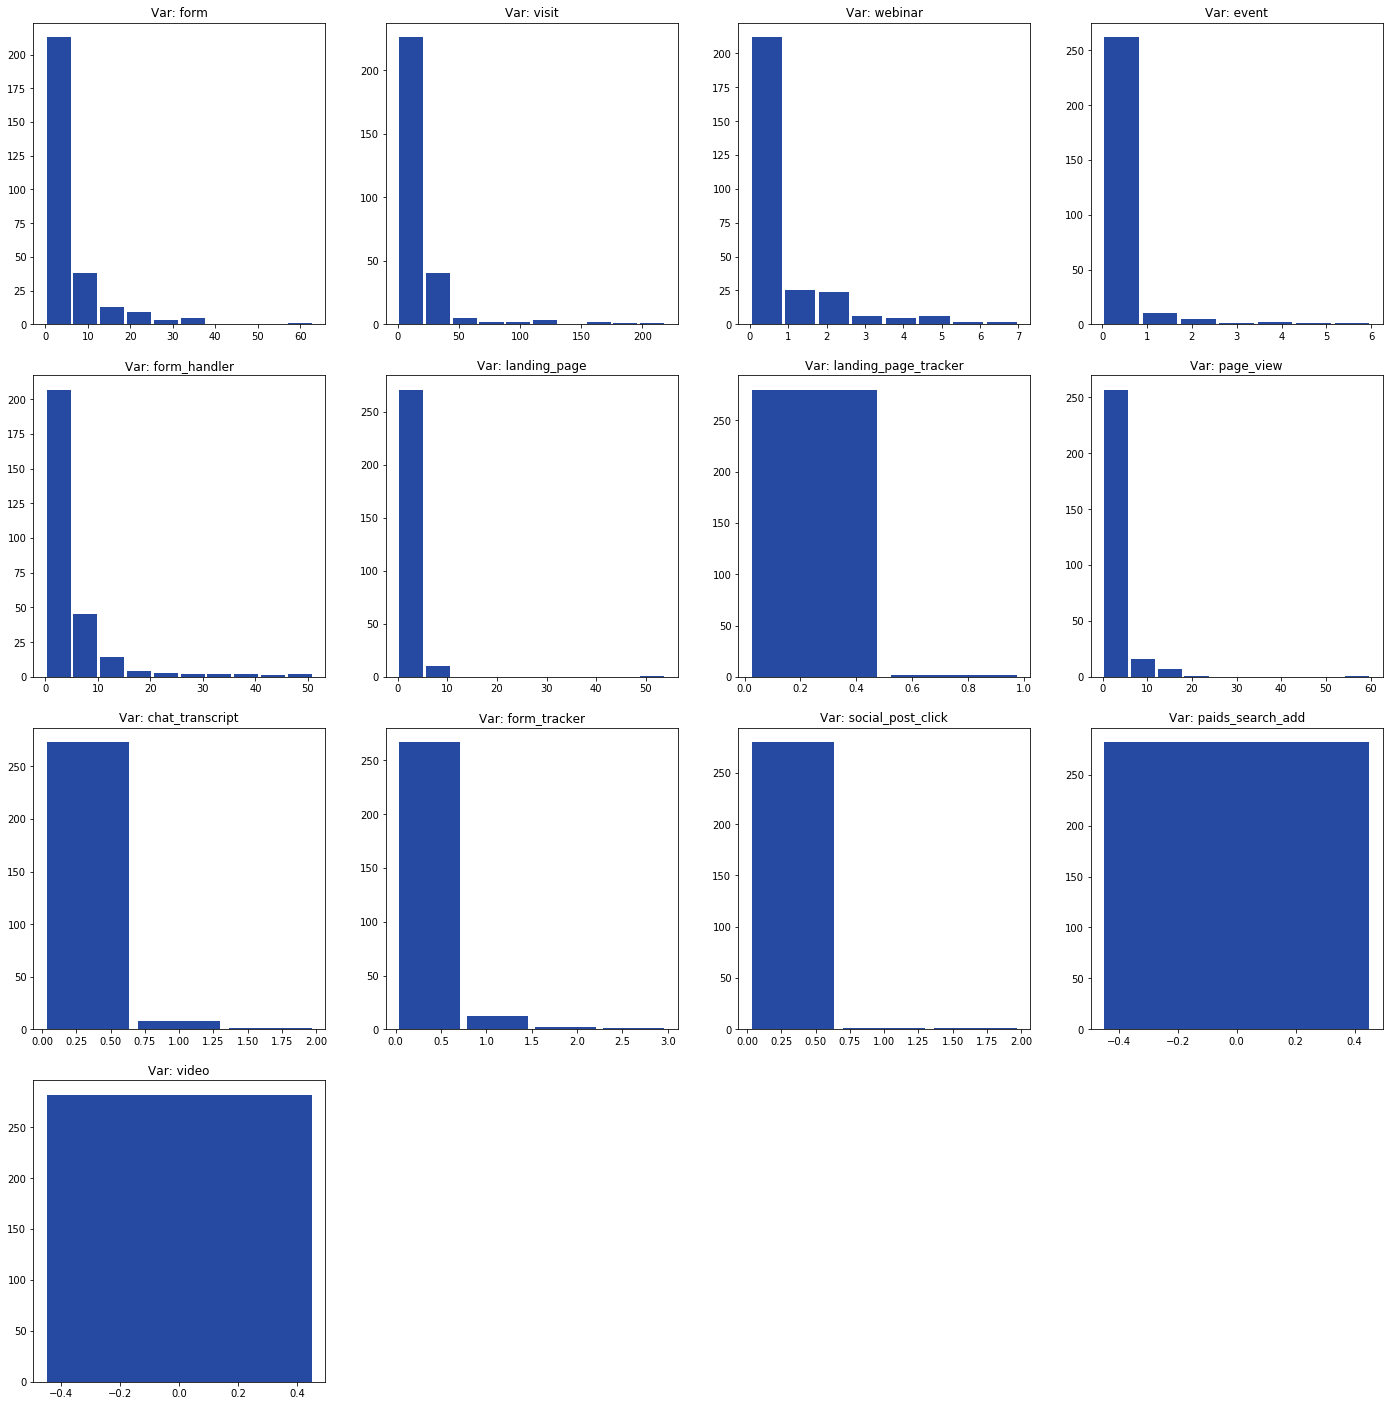

In [8]:
#Arreglo con las columnas que tienen informacion del sitio web
arregloColumnasSitioWeb = ["form","visit","webinar","event","form_handler","landing_page","landing_page_tracker","page_view",
                            "chat_transcript","form_tracker","social_post_click","paids_search_add","video"]

#Particion del grafico en 4 filas y 4 columnas
figure,axes = plt.subplots(nrows=4,ncols=4,figsize=(20,20))

#Se pone una separacion entre los subplot de 3
figure.tight_layout(pad=3.0)

#Se inicializa en 0 la fila del subplot
fila = 0

#Se inicializa en 0 la columna del subplot
columna = 0

#Se recorren las columnas del DataFrame
for i in dfColumnasEstandarizadas.columns:
    
    #Se valida que el nombre de la columna este en el arreglo
    if i in arregloColumnasSitioWeb:
        
        #Se asigna la posicion en el grafico
        ax = axes[fila][columna]
        
        #Se asigna el nombre del titulo
        nombreVariable = i
        
        #Se asigna los datos del histograma
        arregloDatos = dfColumnasEstandarizadas[i]
        
        #Se pinta el grafico
        histogramaVariable(ax,nombreVariable,arregloDatos)
        
        #Se actualiza el valor de la columna con 1 mas
        columna = columna + 1
        
        #Se valida que despues de la actualizacion sea 4
        if columna == 4:
            
            #Se reinicia las columnas 
            columna = 0 
            
            #Se actualiza el valor de la fila con 1 mas
            fila = fila + 1
            
#No se muestra la posicion fila = 4 columna = 2
axes[3][1].axis('off')

#No se muestra la posicion fila = 4 columna = 3
axes[3][2].axis('off')

#No se muestra la posicion fila = 4 columna = 4
axes[3][3].axis('off')

#Se salva el grafico como una imagen
plt.savefig("../01. Flat Files/dataPQL_hist_sitio_web.png")

#Se muestra el grafico
plt.show()

#Se elimna la variaible figure,axes,fila,columna,nombreVariable,i,arregloDatos,ax,arregloColumnasSitioWeb
del figure,axes,fila,columna,nombreVariable,i,arregloDatos,ax,arregloColumnasSitioWeb

<b>Paso 8.</b> Se grafica el comportamiento de las variables de visitas acumuladas a la aplicacion  

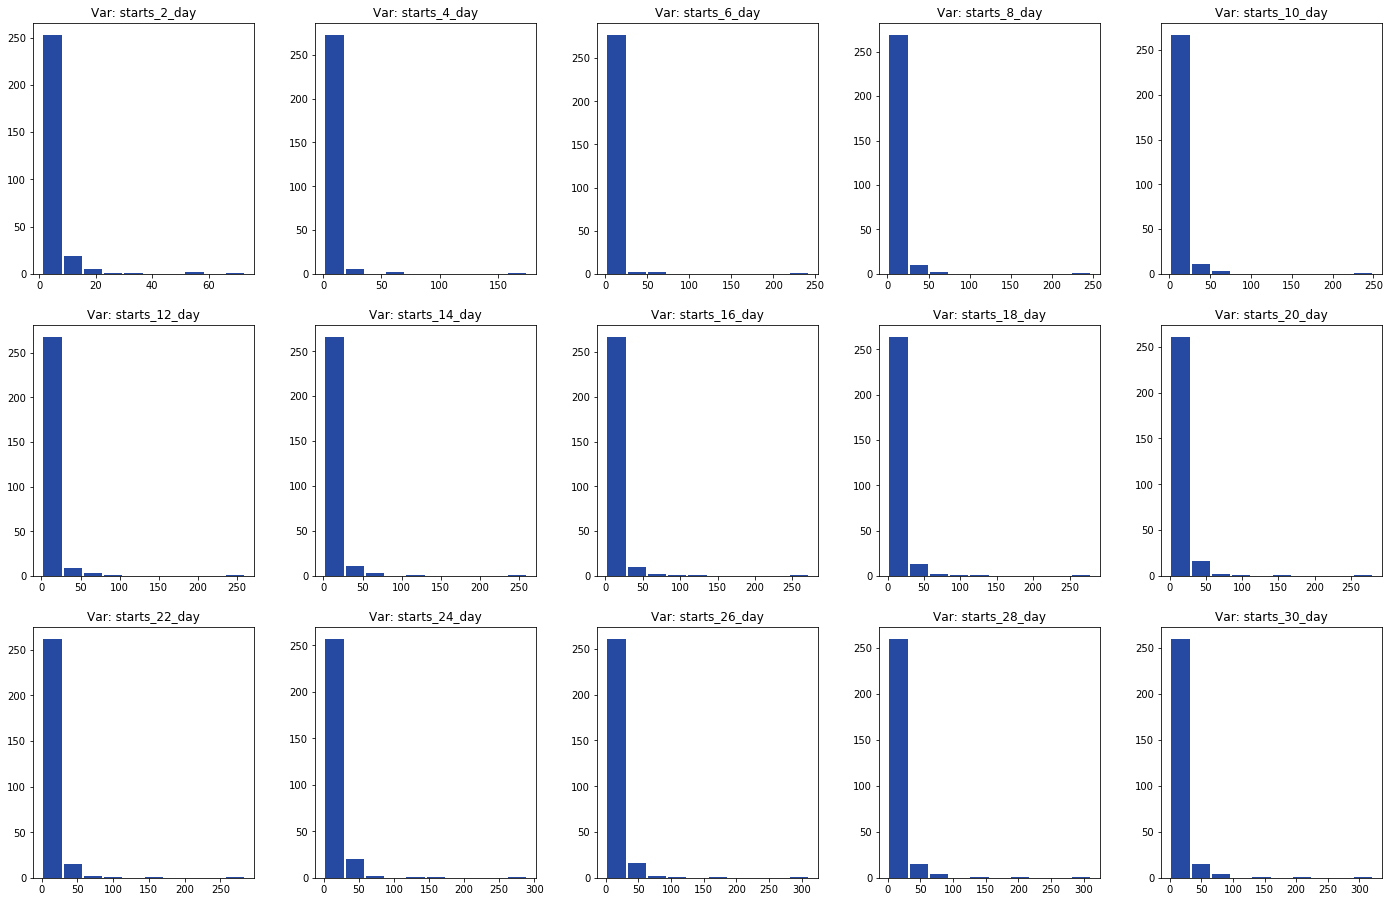

In [9]:
#Particion del grafico en 3 filas y 5 columnas
figure,axes = plt.subplots(nrows=3,ncols=5,figsize=(20,13))

#Se pone una separacion entre los subplot de 3
figure.tight_layout(pad=3.0)

#Se inicializa en 0 la fila del subplot
fila = 0

#Se inicializa en 0 la columna del subplot
columna = 0

#Se recorren las columnas del DataFrame
for i in dfColumnasEstandarizadas.columns:
    
    #Se valida que contenga "starts" "day" y no "delta"
    if "starts" in i and "day" in i and "delta" not in i:
        
        #Se asigna la posicion en el grafico
        ax = axes[fila][columna]
        
        #Se asigna el nombre del titulo
        nombreVariable = i
        
        #Se asigna los datos del histograma
        arregloDatos = dfColumnasEstandarizadas[i]
        
        #Se pinta el grafico
        histogramaVariable(ax,nombreVariable,arregloDatos)
        
        #Se actualiza el valor de la columna con 1 mas
        columna = columna + 1
        
        #Se valida que despues de la actualizacion sea 5
        if columna == 5:
            
            #Se reinicia las columnas
            columna = 0 
            
            #Se actualiza el valor de la fila con 1 mas
            fila = fila + 1

#Se salva el grafico como una imagen
plt.savefig("../01. Flat Files/dataPQL_hist_starts_day.png")

#Se muestra el grafico
plt.show()

#Se elimna la variaible figure,axes,fila,columna,nombreVariable,i,arregloDatos,ax
del figure,axes,fila,columna,nombreVariable,i,arregloDatos,ax

<b>Paso 9.</b> Se grafica el comportamiento del delta de los ingresos a la aplicacion

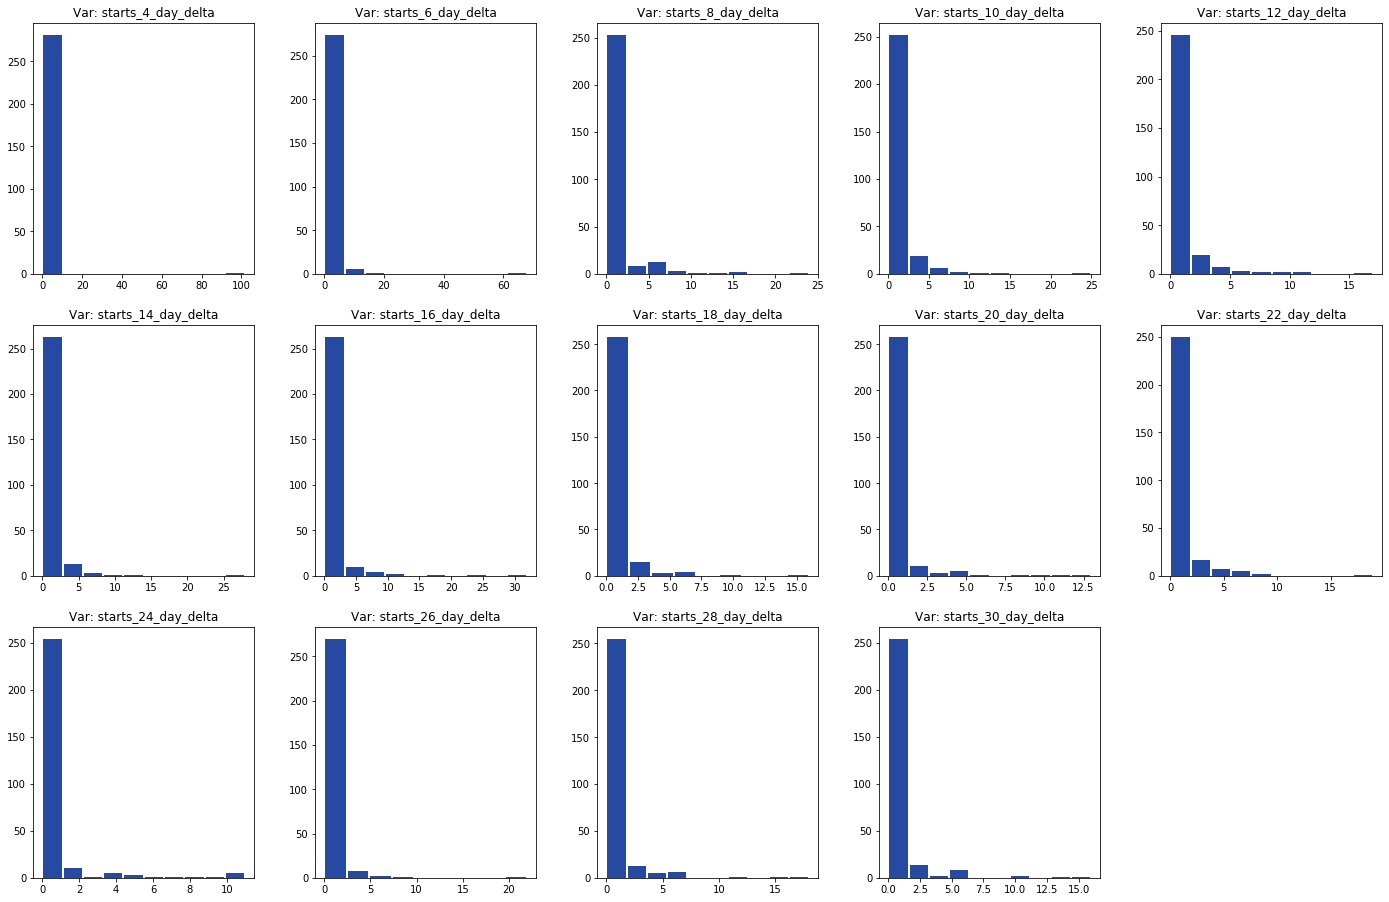

In [10]:
#Particion del grafico en 3 filas y 5 columnas
figure,axes = plt.subplots(nrows=3,ncols=5,figsize=(20,13))

#Se pone una separacion entre los subplot de 3
figure.tight_layout(pad=3.0)

#Se inicializa en 0 la fila del subplot
fila = 0

#Se inicializa en 0 la columna del subplot
columna = 0

#Se recorren las columnas del DataFrame
for i in dfColumnasEstandarizadas.columns:
    
    #Se valida que contenga "starts" "day" y "delta"
    if "starts" in i and "day" in i and "delta" in i:
        
        #Se asigna la posicion en el grafico
        ax = axes[fila][columna]
        
        #Se asigna el nombre del titulo
        nombreVariable = i
        
        #Se asigna los datos del histograma
        arregloDatos = dfColumnasEstandarizadas[i]
        
        #Se pinta el grafico
        histogramaVariable(ax,nombreVariable,arregloDatos)
        
        #Se actualiza el valor de la columna con 1 mas
        columna = columna + 1
        
        #Se valida que despues de la actualizacion sea 5
        if columna == 5:
            
            #Se reinicia las columnas
            columna = 0 
            
            #Se actualiza el valor de la fila con 1 mas
            fila = fila + 1
            
#No se muestra la posicion fila = 3 columna = 5
axes[2][4].axis('off')

#Se salva el grafico como una imagen
plt.savefig("../01. Flat Files/dataPQL_hist_starts_day_delta.png")

#Se muestra el grafico
plt.show()

#Se elimna la variaible figure,axes,fila,columna,nombreVariable,i,arregloDatos,ax
del figure,axes,fila,columna,nombreVariable,i,arregloDatos,ax

<b>Paso 10.</b> Se grafica el comportamiento de los failures que hay en la aplicacion

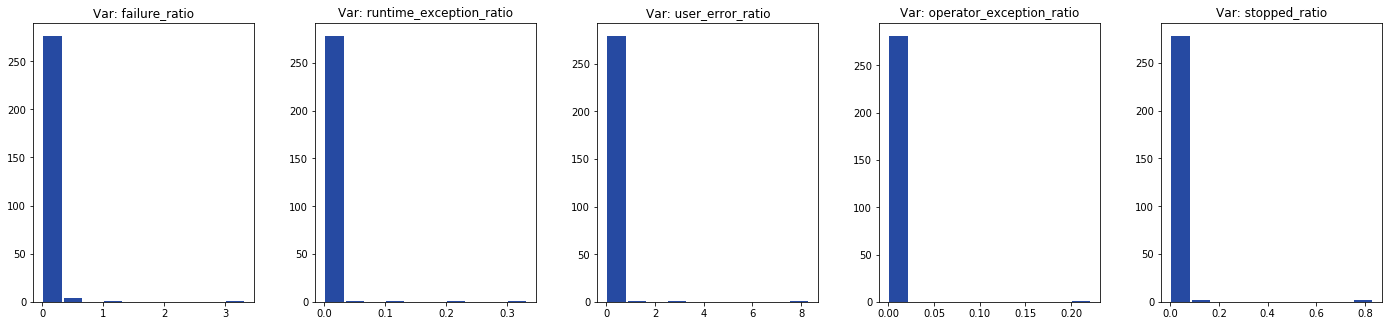

In [11]:
#Arreglo con las columnas que tienen informacion de las fallas de la aplicacion
arregloColumnasFailures = ["failure_ratio","runtime_exception_ratio","user_error_ratio","operator_exception_ratio",
                           "stopped_ratio"]

#Particion del grafico en 1 filas y 5 columnas
figure,axes = plt.subplots(ncols=5,figsize=(20,5))

#Se pone una separacion entre los subplot de 3
figure.tight_layout(pad=3.0)

#Se inicializa en 0 la columna del subplot
columna = 0

#Se recorren las columnas del DataFrame
for i in dfColumnasEstandarizadas.columns:
    
    #Se valida que el nombre de la columna este en el arreglo
    if i in arregloColumnasFailures:
        
        #Se asigna la posicion en el grafico
        ax = axes[columna]
        
        #Se asigna el nombre del titulo
        nombreVariable = i
        
        #Se asigna los datos del histograma
        arregloDatos = dfColumnasEstandarizadas[i]
        
        #Se pinta el grafico
        histogramaVariable(ax,nombreVariable,arregloDatos)
        
        #Se actualiza el valor de la columna con 1 mas
        columna = columna + 1
                    
#Se salva el grafico como una imagen
plt.savefig("../01. Flat Files/dataPQL_hist_failures.png")

#Se muestra el grafico
plt.show()

#Se elimna la variaible figure
del figure,axes,columna,nombreVariable,i,arregloDatos,ax,arregloColumnasFailures

## Transformaciones - Modelo de Testeo

<b>Paso 11.</b> Funcion que elimina las variables del sitio web que solo tienen un valor

In [12]:
def eliminarVariables(dfColumnasEstandarizadas):
    
    #Se elimnan las columnas que no se utilizaran dado que solo tienen un valor
    return dfColumnasEstandarizadas.drop(columns=["paids_search_add","video"])

<b>Paso 12.</b> Funcion que se encarga de la codificacion numerica de los campos texto del DataFrame

In [13]:
def codString(dfColumnasEstandarizadas):
    
    #Importa la libreria LabelEncoder
    from sklearn.preprocessing import LabelEncoder
    
    #Se inicializa el LabelEncoder
    enc = LabelEncoder()
    
    #Se crea un diccionario para las transformaciones
    diccionarioEncoder = {}
    
    #DataFrame que se va a retornar
    dfRetorno = pd.concat([dfColumnasEstandarizadas.loc[:,"is_won"],dfColumnasEstandarizadas.loc[:,"country_new":]],axis=1)
    
    for i in dfRetorno.columns:
           
        #Se realiza la codificacion
        enc.fit(dfRetorno[i])
        
        #Obtencion de la codificacion
        diccionarioEncoder.update({i:enc.classes_})
        
        #Se realiza la actulizacion del campo
        dfRetorno[i] = enc.transform(dfRetorno[i])
    
    #Elimina la variable del LabelEncoder
    del enc
        
    return diccionarioEncoder,dfRetorno

<b>Paso 13.</b> Funcion encargada de ajustar los datos del DataFrame a una funcion de probabilidad normal estandar

In [14]:
def normalizacion(dfColumnasEstandarizadas):
    
    #Importa la libreria Normalizer
    from sklearn.preprocessing import Normalizer
    
    #Se inicializa el Normalizer
    norm = Normalizer()
    
    #Se crea un DataFrame vacio
    dfRetorno = pd.DataFrame()
    
    for i in dfColumnasEstandarizadas.columns:
        
        #Se obtiene el tipo de la columna
        tipoCol = str(dfColumnasEstandarizadas[i].dtype.type)
        
        #Se valida que si la columna es numerica y es diferente de id
        if ('int' in tipoCol or 'float' in tipoCol) and i != "id":
            
            #Se realiza la codificacion
            norm.fit(dfColumnasEstandarizadas[i].values.reshape(1,-1))
            
            #Se realiza la actulizacion con el nuevo valor
            dfRetorno[i] = norm.transform(dfColumnasEstandarizadas[i].values.reshape(1,-1))[0]
    
    #Elimna la variable Normalizer         
    del norm
    
    return dfRetorno

<b>Paso 14.</b> Funcion que se encarga de separar los datos entre la varaible a predecir y las predictorias

In [15]:
def separacionDataFrameModelo(dfModel):
    
    #Se elimina la columna is_won del arreglo 
    X = dfModel.drop(columns=["is_won"])
    
    #Se toma solo la columna is_won del arreglo
    Y = dfModel["is_won"]
    
    return X,Y

## Creacion - Modelo de Testeo

<b>Paso 15.</b> Funcion que se encarga de ejecutar un modelo, dado por parametro, con el fin de realizar un Feature Selection con Cross Validation

In [16]:
def modeloFeatureSelection(X,Y,model):

    #Importa el feature selection con cross validation
    from sklearn.feature_selection import RFECV

    #Importa el modelo de corss validation
    from sklearn.model_selection import StratifiedKFold

    #Se crea un modelo de feature selection
    selector = RFECV(estimator=model,cv=10,scoring='accuracy',min_features_to_select=10)
    
    #Importa la funcion train test split
    from sklearn.model_selection import train_test_split

    #Se realiza el entrenamiento del modelo
    selector.fit(X,Y)
    
    #Vector con el soporte de seleccion
    array = selector.support_
    
    #Se crea un DataFrame con las columnas y el soporte
    variableSelect = pd.DataFrame([X.columns,array]).transpose()
    
    #Se cambia el nombre de las columnas
    variableSelect.columns = ["variable","seleccionar"]
    
    #Se selecciona la columna variable
    variableSelect = variableSelect[variableSelect["seleccionar"] == True]["variable"]
    
    #Se importa el reporte de clasificacion
    from sklearn.metrics import classification_report

    #Se predice con los datos de testo
    YTestPredict = selector.predict(X)

    #Reporte de clasificacion
    resultado = pd.DataFrame.from_dict(classification_report(Y,YTestPredict,output_dict=True))
    resultado = resultado.rename(columns={'0':'False','1':'True'}).reset_index()
    
    #Se importa la matriz de confusion
    from sklearn.metrics import confusion_matrix

    #Se ejecuta la matriz de confusion 
    matrixConfusion = pd.DataFrame(confusion_matrix(Y, YTestPredict))
    
    return selector,variableSelect,resultado,matrixConfusion

<b>Paso 16.</b> Funcion que se encarga de ejecutar un modelo Knn

In [17]:
def modeloKnn(X,Y):

    #Importa la funcion train test split
    from sklearn.model_selection import train_test_split

    #Se obtienen los valores de entrenamiento y testeo
    XTrain,XTest,YTrain,YTest = train_test_split(X,Y,test_size = 0.3,random_state = 101)
    
    from sklearn.neighbors import KNeighborsClassifier
    
    #Knn
    knn = KNeighborsClassifier()
    knn.fit(XTrain,YTrain)
    
    #Se importa el reporte de clasificacion
    from sklearn.metrics import classification_report

    #Se predice con los datos de testo
    YTestPredict = knn.predict(XTest)

    #Reporte de clasificacion
    resultado = pd.DataFrame.from_dict(classification_report(YTest,YTestPredict,output_dict=True))
    resultado = resultado.rename(columns={'0':'False','1':'True'}).reset_index()
    
    #Se importa la matriz de confusion
    from sklearn.metrics import confusion_matrix

    #Se ejecuta la matriz de confusion 
    matrixConfusion = pd.DataFrame(confusion_matrix(YTest, YTestPredict))
    
    return knn,X.columns,resultado,matrixConfusion

<b>Paso 17.</b> Funcion encargada de ejecutar un modelo de Knn con las columnas pasados por parametro

In [18]:
def applyKnn(dfColumnasEstandarizadas,columnasSeleccion):
    
    #Se estandarizan las columnas elimnando las columnas no funcionales
    dfColumnasEstandarizadas = eliminarVariables(dfColumnasEstandarizadas)

    #Se codifican las columnas string
    dicEncoder,dfEncoder = codString(dfColumnasEstandarizadas)
    
    #Se realiza la normalizacion de las columnas numericas
    dfZTransformacion = normalizacion(dfColumnasEstandarizadas)
    
    #Concatena el nuevo DataFrame
    dfModel = pd.concat([dfEncoder,dfZTransformacion],axis=1)
    
    #Separa las variables
    X,Y = separacionDataFrameModelo(dfModel)
    
    X = X[columnasSeleccion]

    knn,seleccion,resultado,matrixConfusion = modeloKnn(X,Y)
    
    return knn,seleccion,resultado,matrixConfusion,dicEncoder

## Graficos - Modelo de Testeo

<b>Paso 18.</b> Funcion encargada de generar los label del grafico de la matriz de confusion

In [19]:
def labelsGraficoMatrix(dfResultadoAgrupado,dfMatrixConfusion,dicEncoder):
    
    #Valor string de la media del accuracy
    accuracyMean = str(round(dfResultadoAgrupado.loc[0]["accuracy"]*100,2))
        
    #Concatenacion para el titulo del grafico
    titulo = "model accuracy : "+accuracyMean+"%"
    
    #Arreglo con los valores de las etiquetas del eje X
    xLabel = []

    #Arreglo con los valores de las etiquetas del eje y
    yLabel = []
    
    #Se crea la matriz de recall
    recall = dfMatrixConfusion.transpose().to_numpy()

    for i in range(len(dicEncoder["is_won"])):
        
        #Valor del recall
        mean = str(round((recall[i,i]/np.sum(recall,axis=0)[i])*100,2))
                
        #Valor de la categoria
        label = str(dicEncoder["is_won"][i])
        
        #Concatenacion del label agregar
        agregar = ""+label+"\n Recall = "+mean+"%"
        
        #Se agrega el label
        xLabel.append(agregar)
        
    #Se crea la matriz de recall
    precision = dfMatrixConfusion.to_numpy()

    for i in range(len(dicEncoder["is_won"])):
    
        #Valor del recall
        mean = str(round((precision[i,i]/np.sum(precision,axis=0)[i])*100,2))
                
        #Valor de la categoria
        label = str(dicEncoder["is_won"][i])
        
        #Concatenacion del label agregar
        agregar = ""+label+"            \n Precision = "+mean+"%"
        
        #Se agrega el label       
        yLabel.append(agregar)
    
    return titulo,xLabel,yLabel

<b>Paso 19.</b> Funcion encargada de generar el mapa de calor a partir de la matriz de confusion

In [20]:
def graficoConfusionMatrix(dfMatrixConfusion,dfResultadoAgrupado,nombreArchivo,dicEncoder):
    
    #Se crea un graficon con tamaño 10 de ancho y 2.5 de alto
    fig, ax = plt.subplots(figsize=(6.5,2.5))
    
    #Se muestra todo el grafico
    fig.tight_layout()
    
    #Se extrae la data del DataFrame
    dataHeat = dfMatrixConfusion.transpose().to_numpy()
    
    #Se adiciona el mapa de calor al grafico
    ax = sns.heatmap(dataHeat,annot=True,cmap="Blues",annot_kws={"size":14},fmt='g',cbar = False)
    
    #Se obtienen el titulo y los label de los ejes
    titulo,xLabel,yLabel = labelsGraficoMatrix(dfResultadoAgrupado,dfMatrixConfusion,dicEncoder)

    #Se agrega el titulo
    plt.title(titulo + "\n",fontsize=9,fontweight='bold')
    
    #Se agrega el titulo del eje y
    plt.ylabel('Predicted label \n',fontsize=13,fontweight='bold')
    
    #Se agrega el titulo del eje x
    plt.xlabel('Actual label \n',fontsize=13,fontweight='bold')
    
    #Se agrega la etiqueta de datos del eje x
    plt.xticks(np.arange(len(xLabel))+0.5,xLabel,fontsize=14)
    
    #Se agrega la etiqueta de datos del eje y
    plt.yticks(np.arange(len(yLabel))+0.5,yLabel,fontsize=14,rotation=0)
    
    #Se posiciona el eje x arriba
    ax.xaxis.tick_top() 
    
    #Se posiciona los labels arriba
    ax.xaxis.set_label_position('top')

    #Se salva el grafico como una imagen
    plt.savefig("../01. Flat Files/dataPQL_"+nombreArchivo+".png",bbox_inches = "tight")

    #Se muestra el grafico
    plt.show()

## Aplicacion - Modelo de Testeo

<b>Paso 20.</b> Funcion encargada de ejecutar un modelo de Arbol Clasificatorio de Desicion

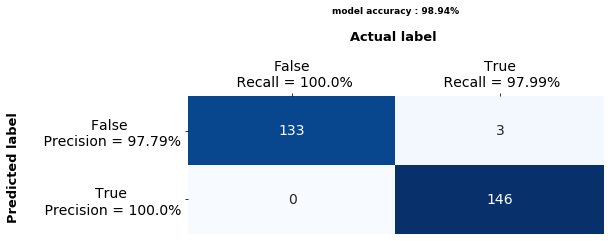

In [21]:
def applyArbolDesicion(dfColumnasEstandarizadas):
    
    #Se estandarizan las columnas elimnando las columnas no funcionales
    dfColumnasEstandarizadas = eliminarVariables(dfColumnasEstandarizadas)

    #Se codifican las columnas string
    dicEncoder,dfEncoder = codString(dfColumnasEstandarizadas)
    
    #Se realiza la normalizacion de las columnas numericas
    dfZTransformacion = normalizacion(dfColumnasEstandarizadas)
    
    #Concatena el nuevo DataFrame
    dfModel = pd.concat([dfEncoder,dfZTransformacion],axis=1)
    
    #Separa las variables
    X,Y = separacionDataFrameModelo(dfModel)
    
    from sklearn.tree import DecisionTreeClassifier
    
    #Arbol de decision
    tree = DecisionTreeClassifier()
    
    #Variables resultado de la ejecucion del modelo
    selector,variableSelect,resultado,matrixConfusion = modeloFeatureSelection(X,Y,tree)

    #Se grafica el resultado del modelo
    graficoConfusionMatrix(matrixConfusion,resultado,"arbolDesicion",dicEncoder)
    
    return selector,variableSelect

modelAD,varaiblesAD = applyArbolDesicion(dfColumnasEstandarizadas)

<b>Paso 21.</b> Funcion encargada de ejecutar un modelo de Naive Bayes Clasificatorio

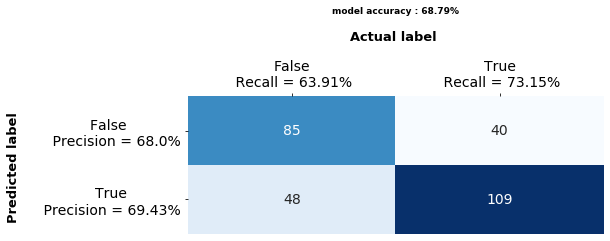

In [22]:
def applyNaiveBayes(dfColumnasEstandarizadas):

    #Se estandarizan las columnas elimnando las columnas no funcionales
    dfColumnasEstandarizadas = eliminarVariables(dfColumnasEstandarizadas)

    #Se codifican las columnas string
    dicEncoder,dfEncoder = codString(dfColumnasEstandarizadas)
    
    #Se realiza la normalizacion de las columnas numericas
    dfZTransformacion = normalizacion(dfColumnasEstandarizadas)
    
    #Concatena el nuevo DataFrame
    dfModel = pd.concat([dfEncoder,dfZTransformacion],axis=1)
    
    #Separa las variables
    X,Y = separacionDataFrameModelo(dfModel)
    
    from sklearn.naive_bayes import ComplementNB
    
    #Naive Bayes
    naiveBayes = ComplementNB()
    
    #Variables resultado de la ejecucion del modelo
    selector,variableSelect,resultado,matrixConfusion = modeloFeatureSelection(X,Y,naiveBayes)

    #Se grafica el resultado del modelo
    graficoConfusionMatrix(matrixConfusion,resultado,"naiveBayes",dicEncoder)
    
    return selector,variableSelect
    
modelNB,variablesNB = applyNaiveBayes(dfColumnasEstandarizadas)

<b>Paso 22.</b> Funcion encargada de ejecutar un modelo de Regresion Logistica clasificatoria

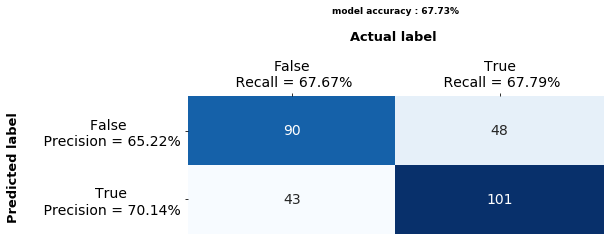

In [23]:
def applyLogistic(dfColumnasEstandarizadas):

    #Se estandarizan las columnas elimnando las columnas no funcionales
    dfColumnasEstandarizadas = eliminarVariables(dfColumnasEstandarizadas)

    #Se codifican las columnas string
    dicEncoder,dfEncoder = codString(dfColumnasEstandarizadas)
    
    #Se realiza la normalizacion de las columnas numericas
    dfZTransformacion = normalizacion(dfColumnasEstandarizadas)
    
    #Concatena el nuevo DataFrame
    dfModel = pd.concat([dfEncoder,dfZTransformacion],axis=1)
    
    #Separa las variables
    X,Y = separacionDataFrameModelo(dfModel)
    
    from sklearn.linear_model import LogisticRegression
    
    #LogisticRegression
    logReg = LogisticRegression(max_iter=1000)
    
    #Variables resultado de la ejecucion del modelo
    selector,variableSelect,resultado,matrixConfusion = modeloFeatureSelection(X,Y,logReg)
        
    #Se grafica el resultado del modelo
    graficoConfusionMatrix(matrixConfusion,resultado,"logReg",dicEncoder)
    
    return selector,variableSelect
    
modelLogReg,variablesLogReg = applyLogistic(dfColumnasEstandarizadas)

<b>Paso 23.</b> Funcion encargada de ejecutar un modelo de Knn con las columnas que selecciono el Arbol Clasifcatorio de Desicion

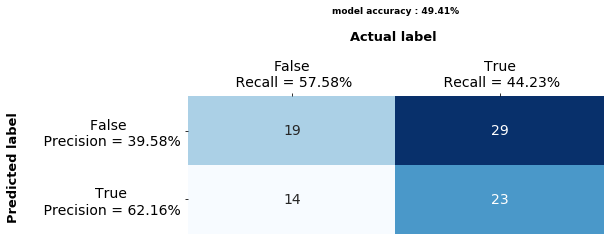

In [24]:
#Se aplica el Knn con las columnas del Arbol de Desicion
knn1,seleccionKnn1,resultadoKnn1,matrixConfusionKnn1,dicEncoderKnn1 = applyKnn(dfColumnasEstandarizadas,varaiblesAD)

#Se grafica el resultado del modelo
graficoConfusionMatrix(matrixConfusionKnn1,resultadoKnn1,"Knn1",dicEncoderKnn1)

<b>Paso 24.</b> Funcion encargada de ejecutar un modelo de Knn con las columnas que selecciono el Naive Bayes Clasificatorio

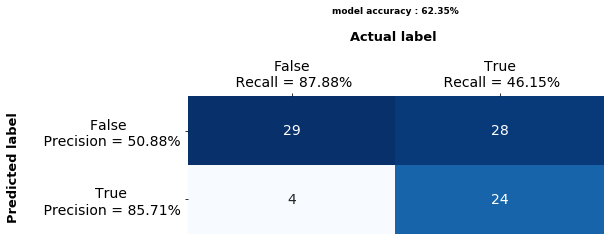

In [25]:
#Se aplica el Knn con las columnas del Navie Bayes
knn2,seleccionKnn2,resultadoKnn2,matrixConfusionKnn2,dicEncoderKnn2 = applyKnn(dfColumnasEstandarizadas,variablesNB)

#Se grafica el resultado del modelo
graficoConfusionMatrix(matrixConfusionKnn2,resultadoKnn2,"Knn2",dicEncoderKnn2)

<b>Paso 25.</b> Funcion encargada de ejecutar un modelo de Knn con las columnas que selecciono la Regresion Logistica

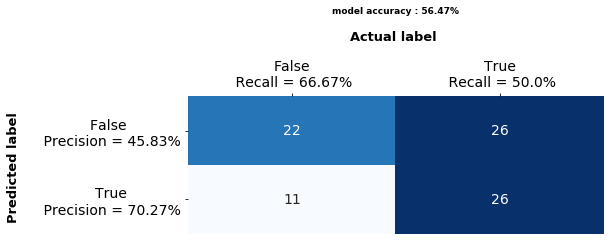

In [26]:
#Se aplica el Knn con las columnas de la Regresion Logistica
knn3,seleccionKnn3,resultadoKnn3,matrixConfusionKnn3,dicEncoderKnn3 = applyKnn(dfColumnasEstandarizadas,variablesLogReg)

#Se grafica el resultado del modelo
graficoConfusionMatrix(matrixConfusionKnn3,resultadoKnn3,"Knn3",dicEncoderKnn3)

## Exportacion del modelo

<b>Paso 26.</b> Exporta el modelo con mejor resultado

In [27]:
#Exporta el modelo
pickle.dump(modelNB, open("../01. Flat Files/data_PQL_model", 'wb'))

#Cuales variables se utilizaron
variablesNB.count()

251